## import library and Load Dataset

In [8]:
from libs.MSCTDdataset import MSCTD
from libs.faceExtractor import faceExtractor
from libs.transforms import Compose,toTensor,resize
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle 
import torch

In [9]:
transforms = Compose([resize(dstsize=(224,224)),toTensor()])

training_data = MSCTD(
        mode='train', 
        transformer=transforms,
        download=False,
        root_dir=".",
        read_mode="single")

valid_data = MSCTD(
        mode='validation',
        transformer=transforms,
        download=False,
        root_dir=".",
        read_mode="single")

test_data = MSCTD(
        mode='test',
        transformer=transforms,
        download=False,
        root_dir=".",
        read_mode="single")

# A) Face Analysis

## part 1: Face Extraction

In [4]:
faceExt_train = faceExtractor(mode='train',augmentation=True)
faceExt_train.run(training_data)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/user01/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/user01/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/user01/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/user01/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/user01/.insightface/models/buffalo_l/w600k_r50.onnx recognition


In [6]:
faceExt_valid = faceExtractor(mode='validation',augmentation=False)
faceExt_valid.run(valid_data)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/user01/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/user01/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/user01/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/user01/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/user01/.insightface/models/buffalo_l/w600k_r50.onnx recognition
set det-size: (640, 640)


100%|██████████| 5063/5063 [07:20<00:00, 11.48it/s]


In [ ]:
faceExt_test = faceExtractor(mode='test',augmentation=False)
faceExt_test.run(test_data)

In [4]:
# !python3 faceSentiment.py "--Facedataset_path=." "--workers=2" "--num_head=4" "--Test=0" "--batch_size=128" "--lr=0.001"

Whole train set size: 55544
Validation set size: 3373
  0%|                                                    | 0/40 [00:00<?, ?it/s]

# B) Sentiment anlysis with image's feature

In [169]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34, ResNet34_Weights
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [170]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [171]:
batch_size = 256
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [187]:
weights = ResNet34_Weights.DEFAULT
model = resnet34(weights=weights)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [188]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear_relu_stack = nn.Sequential(

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(16, 3),
        )
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        # y = self.softmax(logits)
        return logits

In [189]:
# model.fc = nn.Linear(2048,3)
model.fc = MLP()


for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if 'layer4' in name:
        param.requires_grad = True
    if 'fc' in name:
        param.requires_grad = True

for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer2.2.conv1.weight False
layer2.2.bn1.weight False
layer2.2.bn1

In [190]:
model.to(device)
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [191]:
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [192]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avgLoss = 0
    correct = 0
    model.train()
    for batch, (X, text, y, idx) in enumerate(dataloader):
        # Compute prediction and loss
        # X = torch.permute(X[0],(0,3,1,2)).float()
        X = X[0].to(device)
        y = torch.squeeze(torch.Tensor(np.array(y).astype(int)).to(torch.long))
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        avgLoss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    correct /= size
    avgLoss /= size
    print(f"\n -Training Accuracy = {(100*correct):>0.1f}%, Avg loss = {avgLoss:>8f} \n")
    return correct, avgLoss

def test_loop(dataloader, model, loss_fn, error):
    size = len(dataloader.dataset)
    loss = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for (X, text, y, idx) in dataloader:
            # Compute prediction and loss
            X = X[0].to(device)
            y = torch.squeeze(torch.Tensor(np.array(y).astype(int)).to(torch.long))
            y = y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= size
    correct /= size
    print(f" -{error} Error: Accuracy = {(100*correct):>0.1f}%, Avg loss = {loss:>8f} \n")
    return correct, loss

In [193]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(log_dir='MLP_Board')

epochs = 5
for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    trainAcc, trainLoss = train_loop(train_dataloader, model, loss_fn, optimizer)
    # writer.add_scalar('Accuracy/train', trainAcc, e)
    # writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(valid_dataloader, model, loss_fn, 'Validation')
    # writer.add_scalar('Accuracy/validation', valAcc, e)
    # writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

Epoch 1
-------------------------------
loss: 1.080559  [    0/20240]
loss: 1.104509  [ 2560/20240]
loss: 1.075855  [ 5120/20240]
loss: 1.082314  [ 7680/20240]
loss: 1.094385  [10240/20240]
loss: 1.090737  [12800/20240]
loss: 1.073270  [15360/20240]
loss: 1.097279  [17920/20240]

 -Training Accuracy = 37.6%, Avg loss = 0.004307 

 -Validation Error: Accuracy = 36.3%, Avg loss = 0.004324 

Epoch 2
-------------------------------
loss: 1.091720  [    0/20240]
loss: 1.099581  [ 2560/20240]
loss: 1.078338  [ 5120/20240]
loss: 1.107041  [ 7680/20240]
loss: 1.072628  [10240/20240]
loss: 1.094342  [12800/20240]
loss: 1.089656  [15360/20240]
loss: 1.096847  [17920/20240]

 -Training Accuracy = 38.6%, Avg loss = 0.004302 

 -Validation Error: Accuracy = 36.3%, Avg loss = 0.004319 

Epoch 3
-------------------------------
loss: 1.078554  [    0/20240]
loss: 1.064265  [ 2560/20240]
loss: 1.094154  [ 5120/20240]
loss: 1.085132  [ 7680/20240]
loss: 1.107550  [10240/20240]
loss: 1.083390  [12800/202

In [194]:
test_loop(test_dataloader, model, loss_fn, 'Test');

 -Test Error: Accuracy = 37.8%, Avg loss = 0.004347 



In [195]:
y_pred = []
y_true = []

with torch.no_grad():
    for (X, temp1, y, temp2)  in test_dataloader:
        # X = torch.permute(X[0],(0,3,1,2)).float()
        X = X[0].to(device)
        y = torch.squeeze(torch.Tensor(np.array(y).astype(int)).to(torch.long))
        y = y.to(device)
        pred = model(X)
        output = pred.argmax(1).cpu().numpy()
        y_pred.extend(output)
        label = y.cpu().numpy()
        y_true.extend(label)

In [197]:
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=['neutral','negative','positive']))

              precision    recall  f1-score   support

     neutral       0.28      0.42      0.34      1298
    negative       0.44      0.63      0.52      2163
    positive       0.00      0.00      0.00      1606

    accuracy                           0.38      5067
   macro avg       0.24      0.35      0.29      5067
weighted avg       0.26      0.38      0.31      5067



/home/user01/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user01/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user01/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


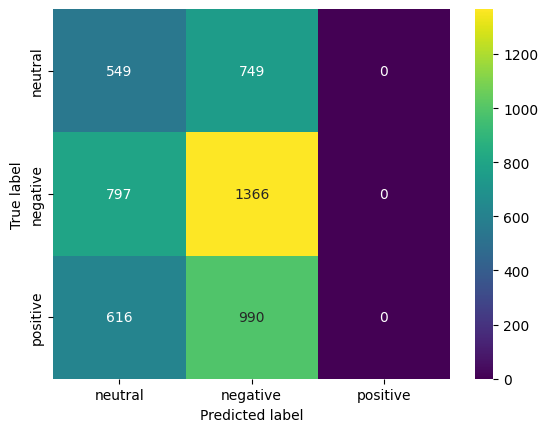

In [198]:
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis',
           xticklabels=['neutral','negative','positive'],
           yticklabels=['neutral','negative','positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'phase1_part2_model.pth')

> We get better accuracy because the model uses whole images instead of faces.

# appendix

In [8]:
import os
import numpy as np
import torch
import glob
import torch.utils.data as data
import cv2
import libs.datasetDownloader as downloader
from torchvision import transforms
from PIL import Image

def read_data_file(root_dir):
    """get train or val images
        return: image list: train or val images list
    """
    image_arr = np.array(glob.glob(os.path.join(root_dir, '*.jpg')))
    try:
        image_nums_arr = np.array([int(s.rsplit('/')[-1][0:-4]) for s in image_arr])
    except :
        image_nums_arr = np.array([int(s.rsplit('\\')[-1][0:-4]) for s in image_arr])

    sorted_image_arr = image_arr[np.argsort(image_nums_arr)]
    return sorted_image_arr.tolist()

def read_index_file(root_dir):
    f = open(root_dir, "r")
    L=f.read().splitlines()
    f.close()
    return list(map(lambda x:list(map(int, x[1:-1].split(','))),L))

def read_text_file(root_dir):
    f = open(root_dir, "r")
    L= f.read().splitlines()
    f.close()
    return L

def read_sentiment_text(root_dir):
    f = open(root_dir, "r")
    L=f.read().splitlines()
    f.close()
    return L

class FACE(data.Dataset):
    def __init__(self,root_dir=".",mode="train",transformer=None) -> None:
        super().__init__()
        self.transformer=transformer
        if os.path.exists(os.path.join(root_dir,"FaceDataset","faceImage",mode, '*.jpg')):
            raise Exception("FaceDataset Not found!")
            
        else:
            self.img_list = sorted(np.array(glob.glob(os.path.join(root_dir,"FaceDataset","faceImage",mode, '*.jpg'))).tolist())
            self.sentiment=read_sentiment_text(root_dir+"/Datasets/"+"sentiment_"+mode+".txt")

    def __getitem__(self, index):
        path=self.img_list[index]
        img=self.transformer(np.array(cv2.imread(path), dtype=np.float32))
        try:
            image_index = int(path.rsplit('/')[-1].split("_")[0])
            face_index = int(path.rsplit('/')[-1].split("_")[1])
        except :
            image_index = int(path.rsplit('\\')[-1].split("_")[0])
            face_index = int(path.rsplit('\\')[-1].split("_")[1])

        sentiment=self.sentiment[image_index]
        
        return img, int(sentiment), image_index, face_index
    
    def __len__(self):
        return len(self.img_list)
    
    

In [11]:
class FACE(data.Dataset):
    def __init__(self,root_dir=".",mode="train",transformer=None) -> None:
        super().__init__()
        self.transformer=transformer
        if os.path.exists(os.path.join("FaceDataset","faceImage","train", '*.jpg')):
            raise Exception("FaceDataset Not found!")
            
        else:
            self.img_list = sorted(np.array(glob.glob(os.path.join("FaceDataset","faceImage","train", '*.jpg'))).tolist())
            self.sentiment=read_sentiment_text(root_dir+"/Datasets/"+"sentiment_"+mode+".txt")

    def __getitem__(self, index):
        path=self.img_list[index]
        img=self.transformer(np.array(cv2.imread(path), dtype=np.float32))
        try:
            image_index = int(path[0:-4].rsplit('/')[-1].split("_")[0])
            face_index = int(path[0:-4].rsplit('/')[-1].split("_")[1])
        except :
            image_index = int(path[0:-4].rsplit('\\')[-1].split("_")[0])
            face_index = int(path[0:-4].rsplit('\\')[-1].split("_")[1])

        sentiment = self.sentiment[image_index]
        
        return img, int(sentiment), image_index, face_index
    
    
    def __len__(self):
        return len(self.img_list)

In [12]:
face_train = FACE(transformer=Compose([resize(dstsize=(400,400)),toTensor()]))
# face_loader = DataLoader(face_train, shuffle=True, batch_size=10)

In [13]:
face_train[1]

(tensor([[[131.0000, 131.0000, 131.9125,  ..., 166.5437, 167.6525, 169.0000],
          [131.0000, 131.6207, 132.8338,  ..., 164.7012, 166.1105, 168.0788],
          [131.8687, 133.1278, 135.0464,  ..., 163.2026, 164.2412, 166.2625],
          ...,
          [ 97.0000, 101.7162, 106.7375,  ...,  67.4563,  66.6738,  66.0000],
          [ 97.0000, 101.7162, 106.7375,  ...,  67.4563,  66.6738,  66.0000],
          [ 97.0000, 101.7162, 106.7375,  ...,  67.4563,  66.6738,  66.0000]],
 
         [[136.0000, 136.0000, 136.9125,  ..., 180.5437, 181.6525, 183.0000],
          [136.0000, 136.6207, 137.8338,  ..., 178.7012, 180.1105, 182.0788],
          [136.8687, 138.1278, 140.0464,  ..., 177.2026, 178.2412, 180.2625],
          ...,
          [ 95.0000,  99.7162, 104.7375,  ...,  61.4562,  61.0000,  61.0000],
          [ 95.0000,  99.7162, 104.7375,  ...,  61.4562,  61.0000,  61.0000],
          [ 95.0000,  99.7162, 104.7375,  ...,  61.4562,  61.0000,  61.0000]],
 
         [[ 97.0000,  97.000

In [14]:
from libs.PRIME.rand_filter import RandomFilter
from libs.PRIME.color_jitter import RandomSmoothColor
from libs.PRIME.diffeomorphism import Diffeo



In [15]:
config_diffeo_sT = 1.
config_diffeo_rT = 1.
config_diffeo_scut = 1.
config_diffeo_rcut = 1.
config_diffeo_cutmin = 2
config_diffeo_cutmax = 500
config_diffeo_alpha = 1.0

config_color_jit_cut = 100
config_color_jit_T = 0.02
config_color_jit_max_freqs = 20

config_rand_filter_kernel_size = 7
config_rand_filter_sigma = 0.5

In [8]:
import torch
import torch.nn as nn
class TransformLayer(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        mean = torch.as_tensor(mean, dtype=torch.float)[None, :, None, None]
        std = torch.as_tensor(std, dtype=torch.float)[None, :, None, None]
        self.mean = nn.Parameter(mean, requires_grad=False)
        self.std = nn.Parameter(std, requires_grad=False)

    def forward(self, x):
        return x.sub(self.mean).div(self.std)

In [16]:
augmentations = []


diffeo = Diffeo(
    sT=config_diffeo_sT, rT=config_diffeo_rT,
    scut=config_diffeo_scut, rcut=config_diffeo_rcut,
    cutmin=config_diffeo_cutmin, cutmax=config_diffeo_cutmax,
    alpha=config_diffeo_alpha, stochastic=True
)
augmentations.append(diffeo)

color = RandomSmoothColor(
    cut=config_color_jit_cut, T=config_color_jit_T,
    freq_bandwidth=config_color_jit_max_freqs, stochastic=True
)
augmentations.append(color)

filt = RandomFilter(
    kernel_size=config_rand_filter_kernel_size,
    sigma=config_rand_filter_sigma, stochastic=True
)
augmentations.append(filt)



In [289]:
def apply(img, aug):
    for i in range(len(img)):
        img_aug = aug(img[i][0]/255)*255
        cv2.imwrite(f'face_aug/{i}.jpg', img_aug.permute(1,2,0).numpy())

In [ ]:
apply(face_train, diffeo)

In [17]:
face_train

(tensor([[[131.0000, 131.0000, 131.9125,  ..., 166.5437, 167.6525, 169.0000],
          [131.0000, 131.6207, 132.8338,  ..., 164.7012, 166.1105, 168.0788],
          [131.8687, 133.1278, 135.0464,  ..., 163.2026, 164.2412, 166.2625],
          ...,
          [ 97.0000, 101.7162, 106.7375,  ...,  67.4563,  66.6738,  66.0000],
          [ 97.0000, 101.7162, 106.7375,  ...,  67.4563,  66.6738,  66.0000],
          [ 97.0000, 101.7162, 106.7375,  ...,  67.4563,  66.6738,  66.0000]],
 
         [[136.0000, 136.0000, 136.9125,  ..., 180.5437, 181.6525, 183.0000],
          [136.0000, 136.6207, 137.8338,  ..., 178.7012, 180.1105, 182.0788],
          [136.8687, 138.1278, 140.0464,  ..., 177.2026, 178.2412, 180.2625],
          ...,
          [ 95.0000,  99.7162, 104.7375,  ...,  61.4562,  61.0000,  61.0000],
          [ 95.0000,  99.7162, 104.7375,  ...,  61.4562,  61.0000,  61.0000],
          [ 95.0000,  99.7162, 104.7375,  ...,  61.4562,  61.0000,  61.0000]],
 
         [[ 97.0000,  97.000

In [9]:
img = face_train[0][0]/255#.astype('int8')
# x = np.resize(img, (379,379,3))
# plt.axis("off")
# plt.imshow(img, interpolation="nearest")
# plt.show()

NameError: name 'face_train' is not defined

In [20]:
diffeo(img)

/home/user01/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[0.1333, 0.1333, 0.1333,  ..., 0.0980, 0.0980, 0.0980],
         [0.1343, 0.1343, 0.1340,  ..., 0.0980, 0.0980, 0.0980],
         [0.1363, 0.1361, 0.1349,  ..., 0.0982, 0.0981, 0.0980],
         ...,
         [0.1206, 0.1212, 0.1231,  ..., 0.0997, 0.0983, 0.0980],
         [0.1108, 0.1113, 0.1139,  ..., 0.0997, 0.0983, 0.0980],
         [0.1059, 0.1063, 0.1092,  ..., 0.0997, 0.0982, 0.0980]],

        [[0.0941, 0.0941, 0.0941,  ..., 0.0667, 0.0667, 0.0667],
         [0.0951, 0.0951, 0.0948,  ..., 0.0667, 0.0667, 0.0667],
         [0.0971, 0.0969, 0.0957,  ..., 0.0668, 0.0667, 0.0667],
         ...,
         [0.0735, 0.0740, 0.0759,  ..., 0.0723, 0.0708, 0.0706],
         [0.0637, 0.0643, 0.0668,  ..., 0.0723, 0.0708, 0.0706],
         [0.0588, 0.0592, 0.0621,  ..., 0.0722, 0.0708, 0.0706]],

        [[0.0667, 0.0667, 0.0667,  ..., 0.0392, 0.0392, 0.0392],
         [0.0676, 0.0677, 0.0673,  ..., 0.0392, 0.0392, 0.0392],
         [0.0696, 0.0694, 0.0682,  ..., 0.0393, 0.0393, 0.

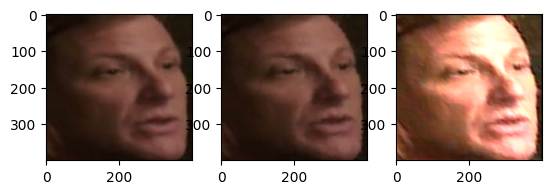

In [22]:
import torchvision.transforms as T

# random_color = RandomSmoothColor(100, 0.02)
# x = T.ToTensor()(img)
# x = T.Resize((200,200))(x)
x= img
x2 = diffeo(x)
x3 = filt(x2)
plt.subplot(1,3,1)
plt.imshow(x.permute(1, 2, 0))
plt.subplot(1,3,2)
plt.imshow(x2.permute(1, 2, 0))
plt.subplot(1,3,3)
plt.imshow(x3.permute(1, 2, 0))


In [8]:
import PIL
from torchvision import transforms
tf = transforms.Compose([transforms.ToPILImage()])

tensor([[[0.1333, 0.1333, 0.1333,  ..., 0.0980, 0.0980, 0.0980],
         [0.1343, 0.1342, 0.1339,  ..., 0.0980, 0.0980, 0.0980],
         [0.1363, 0.1360, 0.1348,  ..., 0.0985, 0.0983, 0.0980],
         ...,
         [0.1206, 0.1214, 0.1226,  ..., 0.1000, 0.0984, 0.0980],
         [0.1108, 0.1114, 0.1135,  ..., 0.0999, 0.0983, 0.0980],
         [0.1059, 0.1063, 0.1092,  ..., 0.0997, 0.0982, 0.0980]],

        [[0.0941, 0.0941, 0.0941,  ..., 0.0667, 0.0667, 0.0667],
         [0.0951, 0.0950, 0.0947,  ..., 0.0667, 0.0667, 0.0667],
         [0.0971, 0.0968, 0.0956,  ..., 0.0671, 0.0669, 0.0667],
         ...,
         [0.0735, 0.0742, 0.0753,  ..., 0.0726, 0.0710, 0.0706],
         [0.0637, 0.0644, 0.0664,  ..., 0.0724, 0.0709, 0.0706],
         [0.0588, 0.0592, 0.0621,  ..., 0.0722, 0.0708, 0.0706]],

        [[0.0667, 0.0667, 0.0667,  ..., 0.0392, 0.0392, 0.0392],
         [0.0676, 0.0676, 0.0672,  ..., 0.0392, 0.0392, 0.0392],
         [0.0696, 0.0694, 0.0682,  ..., 0.0397, 0.0395, 0.

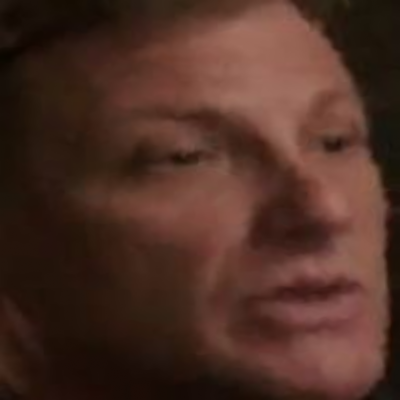

In [30]:
tf(x2)

In [237]:
xxx = torch.cat((face_train[0][0],face_train[1][0]))
xxx.shape

torch.Size([6, 400, 400])

In [244]:
xxx = img.reshape((1,3,400,400))

tensor([[[0.1333, 0.1333, 0.1333,  ..., 0.0980, 0.0980, 0.0980],
         [0.1343, 0.1343, 0.1339,  ..., 0.0980, 0.0980, 0.0980],
         [0.1363, 0.1361, 0.1350,  ..., 0.0980, 0.0980, 0.0980],
         ...,
         [0.1206, 0.1208, 0.1226,  ..., 0.0997, 0.0982, 0.0980],
         [0.1108, 0.1111, 0.1137,  ..., 0.0997, 0.0982, 0.0980],
         [0.1059, 0.1063, 0.1092,  ..., 0.0997, 0.0982, 0.0980]],

        [[0.0941, 0.0941, 0.0941,  ..., 0.0667, 0.0667, 0.0667],
         [0.0951, 0.0950, 0.0947,  ..., 0.0667, 0.0667, 0.0667],
         [0.0971, 0.0969, 0.0958,  ..., 0.0667, 0.0667, 0.0667],
         ...,
         [0.0735, 0.0738, 0.0756,  ..., 0.0722, 0.0708, 0.0706],
         [0.0637, 0.0641, 0.0666,  ..., 0.0722, 0.0708, 0.0706],
         [0.0588, 0.0592, 0.0621,  ..., 0.0722, 0.0708, 0.0706]],

        [[0.0667, 0.0667, 0.0667,  ..., 0.0392, 0.0392, 0.0392],
         [0.0676, 0.0676, 0.0672,  ..., 0.0392, 0.0392, 0.0392],
         [0.0696, 0.0695, 0.0684,  ..., 0.0392, 0.0392, 0.

In [248]:
test_prime = prime_module(xxx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


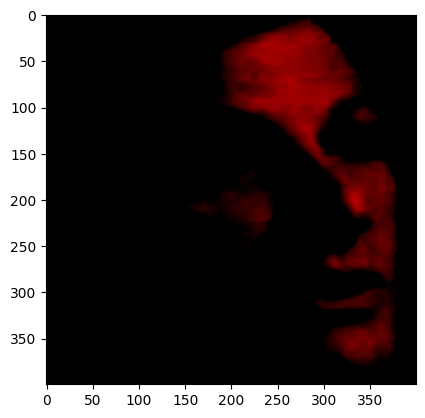

In [269]:
plt.imshow(test_prime[0].permute(1, 2, 0))


In [50]:
x2

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [31]:
x.permute(1, 2, 0).shape

torch.Size([200, 200, 3])

In [104]:
x_device = torch.tensor(img)
x_device.permute(1,2,0).shape

torch.Size([400, 3, 400])

In [100]:
x_device

tensor([[[131.0000, 136.0000,  97.0000],
         [131.0000, 136.0000,  97.0000],
         [131.9125, 136.9125,  97.9125],
         ...,
         [166.5437, 180.5437, 144.5437],
         [167.6525, 181.6525, 145.6525],
         [169.0000, 183.0000, 147.0000]],

        [[131.0000, 136.0000,  97.0000],
         [131.6207, 136.6207,  97.6207],
         [132.8338, 137.8338,  98.8337],
         ...,
         [164.7012, 178.7012, 142.7012],
         [166.1105, 180.1105, 144.1105],
         [168.0788, 182.0788, 146.0788]],

        [[131.8687, 136.8687,  97.8688],
         [133.1278, 138.1278,  99.1278],
         [135.0464, 140.0464, 101.0464],
         ...,
         [163.2026, 177.2026, 141.2026],
         [164.2412, 178.2412, 142.2412],
         [166.2625, 180.2625, 144.2625]],

        ...,

        [[ 97.0000,  95.0000,  60.0000],
         [101.7162,  99.7162,  64.7162],
         [106.7375, 104.7375,  69.7375],
         ...,
         [ 67.4563,  61.4562,  38.4562],
         [ 66.6738,  6

In [101]:
x_deice_diffeo = color.forward(x_device.T)

In [84]:
x_device[(x_deice_diffeo.T - x_device) > 95]

tensor([22.5372, 23.1151, 23.0197, 22.6182, 21.6480, 23.3845, 22.7628, 19.3844,
        19.9478, 20.8418, 17.9793, 16.6023, 17.8888, 19.4538, 14.5414, 15.2046,
        17.1075, 11.7450, 15.7450, 10.7450])

In [85]:
x_deice_diffeo.T

tensor([[[131.0000, 136.0000,  97.0000],
         [131.0000, 136.0000,  97.0000],
         [131.9125, 136.9125,  97.9125],
         ...,
         [166.5437, 180.5437, 144.5437],
         [167.6525, 181.6525, 145.6525],
         [169.0000, 183.0000, 147.0000]],

        [[131.0000, 136.0000,  97.0000],
         [131.6219, 136.6219,  97.6219],
         [132.8380, 137.8381,  98.8381],
         ...,
         [164.7108, 178.7108, 142.7108],
         [166.1119, 180.1119, 144.1119],
         [168.0788, 182.0788, 146.0788]],

        [[131.8687, 136.8687,  97.8688],
         [133.1312, 138.1312,  99.1312],
         [135.0556, 140.0557, 101.0557],
         ...,
         [163.2229, 177.2229, 141.2229],
         [164.2493, 178.2493, 142.2493],
         [166.2625, 180.2625, 144.2625]],

        ...,

        [[ 97.0000,  95.0000,  60.0000],
         [101.6923,  99.6923,  64.6923],
         [106.6833, 104.6833,  69.6833],
         ...,
         [ 67.4690,  61.4651,  38.4767],
         [ 66.6801,  6

In [91]:
y = x_deice_diffeo.numpy().astype('int16')

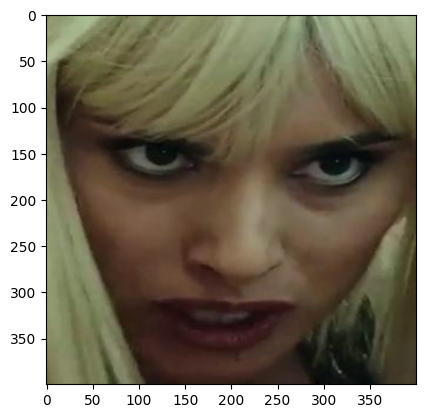

In [92]:
plt.imshow(img.astype('int16').squeeze())


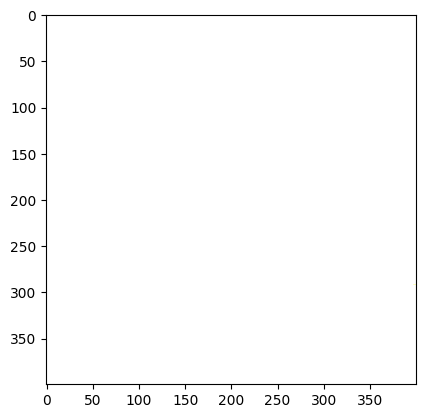

In [105]:
plt.imshow(x_deice_diffeo.permute(1,2,0))

### DataLoader
In the training phase, we use the following loaders.
It can be used in both `single` and `scene` modes 
We just change `collate_fn` to aggregate batch in `scene` mode. so if you want to use `single` mode you have to remove `collate_fn` from argument of Dataloader

In [5]:
def collate_fn(batch):
    return batch

batchSize = 64
train_loader = DataLoader(training_data, shuffle=True, batch_size=batchSize, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batchSize, collate_fn=collate_fn)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batchSize, collate_fn=collate_fn)

## A: Sentiment Histogram

In [6]:
def sentimentDist(data, color):
    sentiment = []
    sentiment.extend(data.sentiment)
    sb.histplot(sentiment, color=color)

(0.0, 9000.0)

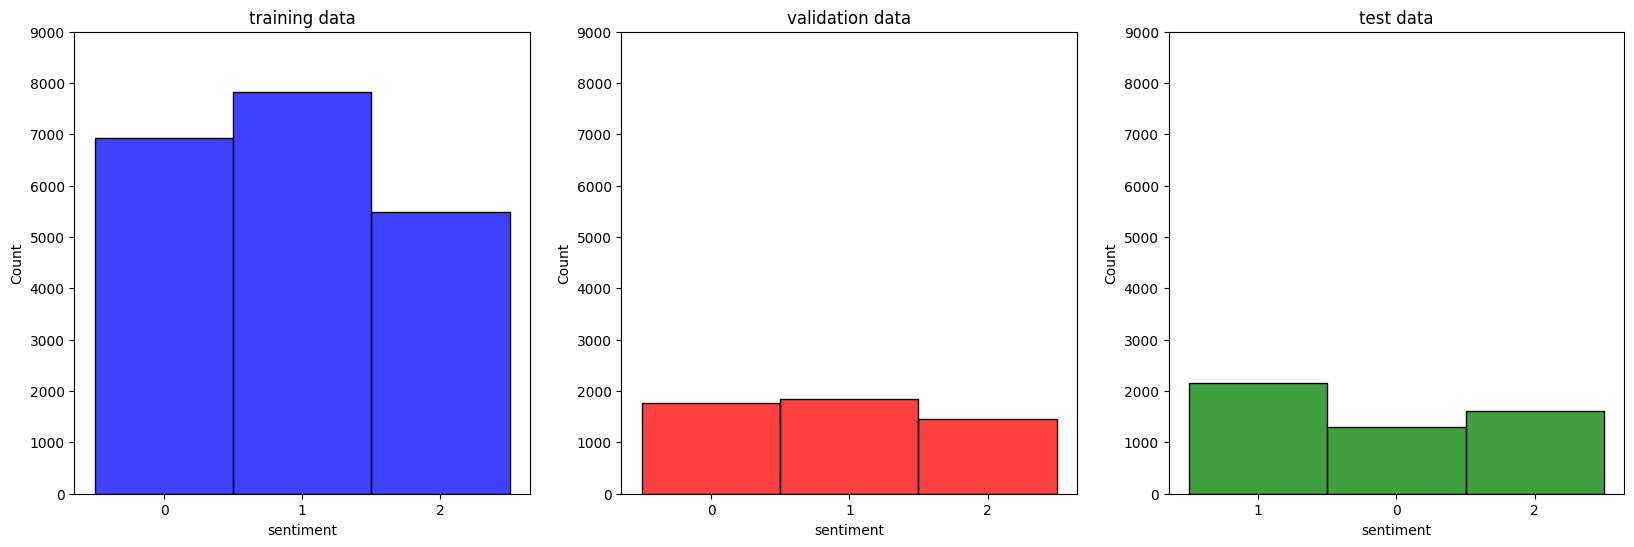

In [7]:
plt.figure(figsize=(20, 6))

plt.subplot(1,3,1)
sentimentDist(training_data, color='blue')
plt.title("training data")
plt.xlabel('sentiment')
plt.ylim((0,9000))

plt.subplot(1,3,2)
sentimentDist(valid_data, 'red')
plt.title("validation data")
plt.xlabel('sentiment')
plt.ylim((0,9000))

plt.subplot(1,3,3)
sentimentDist(test_data, 'green')
plt.title("test data")
plt.xlabel('sentiment')
plt.ylim((0,9000))

> distribution of each class is almost same and this is ok for the training and The Dataset is almost balanced

## B: Mean, variance, and histogram of dialogue(sentence) length

In [8]:
def wordsLength(data):
    length = np.array([len(sentence.split(" ")) for sentence in data.english_text])
    print("mean : ", length.mean())
    print("variance : ", length.var())
    sb.histplot(length, kde=True)
    plt.xlabel('Words Length')

* training data

mean :  6.4644268774703555
variance :  9.247252339514754


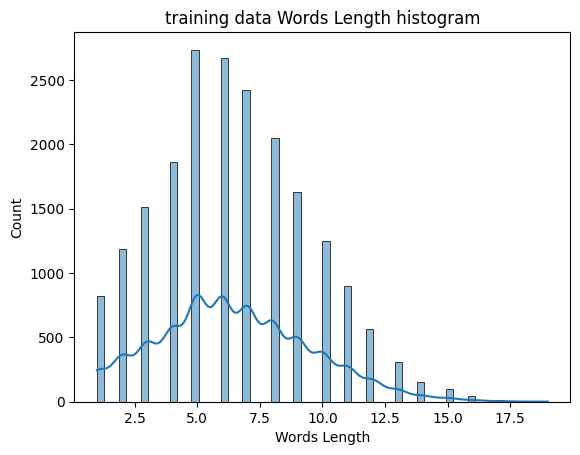

In [9]:
plt.title("training data Words Length histogram")
wordsLength(training_data)

* validation data

mean :  6.310290341694648
variance :  8.630759208611043


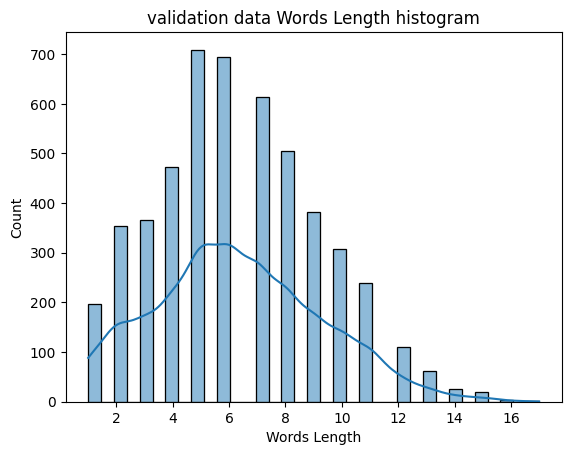

In [10]:
plt.title("validation data Words Length histogram")
wordsLength(valid_data)

* test data

mean :  6.303927373199132
variance :  8.892826494034605


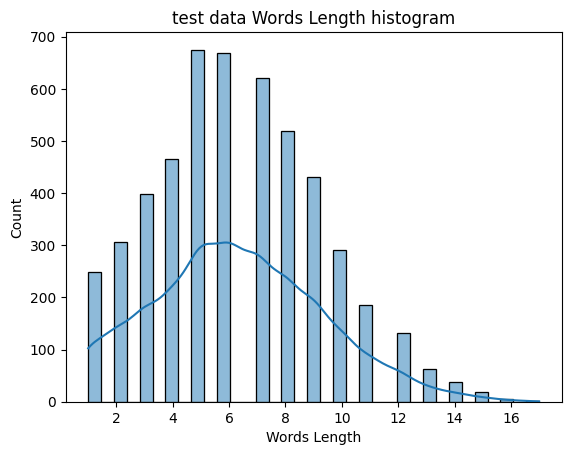

In [11]:
plt.title("test data Words Length histogram")
wordsLength(test_data)

>  distribution, mean, and variance of the Words Lenght histogram are approximately the same on the train, validation, and test Dataset


## C: Mean, variance and histogram of the image's number in conversation

In [12]:
def imageConversation(data):
    numberFrame = np.array([len(index) for index in data.image_index])
    print("mean : ", numberFrame.mean())
    print("variance : ", numberFrame.var())
    sb.histplot(numberFrame, kde=True)
    plt.xlabel('number of image in conversation')

* training data

mean :  9.796708615682478
variance :  17.69632992187156


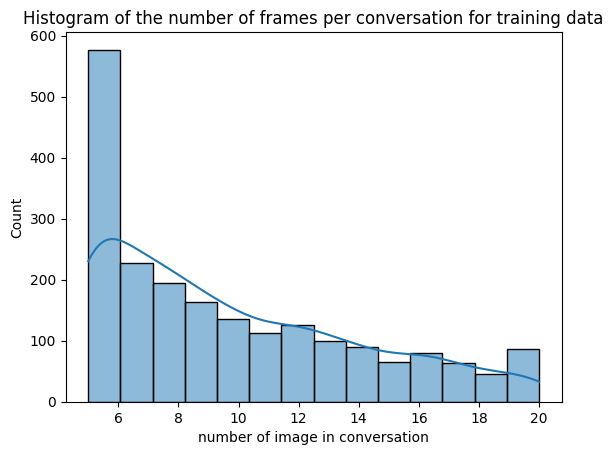

In [13]:
plt.title("Histogram of the number of frames per conversation for training data")
imageConversation(training_data)

* validation data 

mean :  10.045634920634921
variance :  19.253869834971024


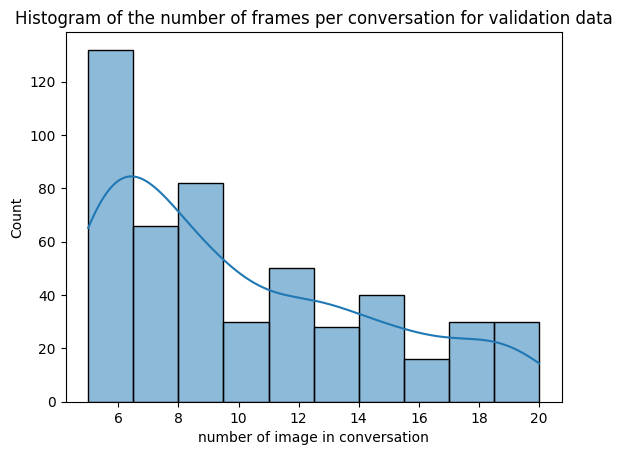

In [14]:
plt.title("Histogram of the number of frames per conversation for validation data")
imageConversation(valid_data)

* test data

mean :  9.954813359528487
variance :  17.752378599742936


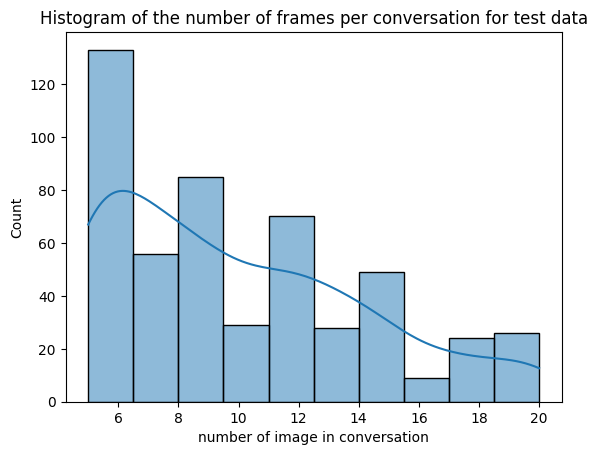

In [15]:
plt.title("Histogram of the number of frames per conversation for test data")
imageConversation(test_data)

> In an average way, most of the conversations have 10 frames and this is fixed for train, test, validation Datasets

## D: Mean, variance and histogram of the face count in each image 

In [16]:
training_data_single = MSCTD(
        mode='train',
        transformer=Compose([resize(dstsize=(1280,640))]),
        download=False,
        root_dir=".",
        read_mode="single")

valid_data_single = MSCTD(
        mode='validation',
        transformer=Compose([resize(dstsize=(1280,640))]),
        download=False,
        root_dir=".",
        read_mode="single")

test_data_single = MSCTD(
        mode='test',
        transformer=Compose([resize(dstsize=(1280,640))]),
        download=False,
        root_dir=".",
        read_mode="single")

### Notice!
It may take a long time to run this cell (2 hours in Colab) so I comment model.We Use two packages `mtcnn` and `dlib`. mtcnn is better than dlib, but it takes much more time. if you want to use dlib package, uncomment `dlibModel` and comment `mtcnnModel`.

In [17]:
# !pip install dlib
# !pip install mtcnn

In [18]:
from mtcnn import MTCNN
def mtcnnModel(data, mode, dataSize):
    data_size = dataSize
    face_count_dict = {}
    detector = MTCNN()
    for i in range(data_size):
        img = np.squeeze(data[i][0])
        img = np.array(img, dtype='uint8')
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        faces = detector.detect_faces(rgb);
        face_count = 0
        for face in faces:
            face_count = face_count+1
        face_count_dict[i+1] = face_count

    with open(f'{mode}_face_count_dict_mtcnn.pkl', 'wb') as f:
        pickle.dump(face_count_dict, f)

In [19]:
# import dlib
# def dlibModel(data, mode, dataSize):
#     data_size = dataSize
#     face_count_dict = {}
#     detector = MTCNN()
#     for i in range(data_size):
#         img = np.squeeze(data[i][0])
#         img = np.array(img, dtype='uint8')
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         detector = dlib.get_frontal_face_detector()
#         faces = detector(gray)
#         face_count = 0
#         for face in faces:
#             face_count = face_count+1
#         face_count_dict[i+1] = face_count

#     with open(f'{mode}_face_count_dict_mtcnn.pkl', 'wb') as f:
#         pickle.dump(face_count_dict, f)

### loading resault dictionary for training test and validation datasets (.pkl Model)

* train dataset

In [20]:
# mtcnnModel(training_data_single,'train', 20240);
# dlibModel(training_data_single,'train', 20240);

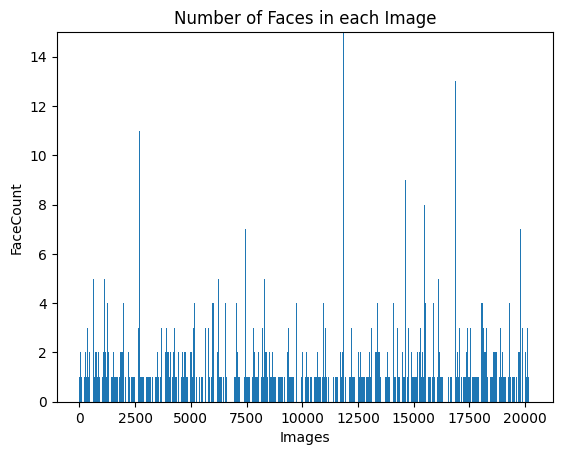

In [21]:
with open('train_face_count_dict_mtcnn.pkl', 'rb') as f:
    face_count_dict = pickle.load(f)


plt.bar(face_count_dict.keys(), face_count_dict.values())
plt.title('Number of Faces in each Image')
plt.xlabel('Images')
plt.ylabel('FaceCount')
plt.ylim((0,15))
plt.show()

In [22]:
face_count_mean = np.mean(list(face_count_dict.values()))
face_count_var = np.var(list(face_count_dict.values()))
face_count_std = np.std(list(face_count_dict.values()))
print(f"mean: {face_count_mean}")
print(f"variance: {face_count_var}")
print(f"Standard Deviation: {face_count_std}")

mean: 1.473814229249012
variance: 3.9426937520504923
Standard Deviation: 1.985621754526902


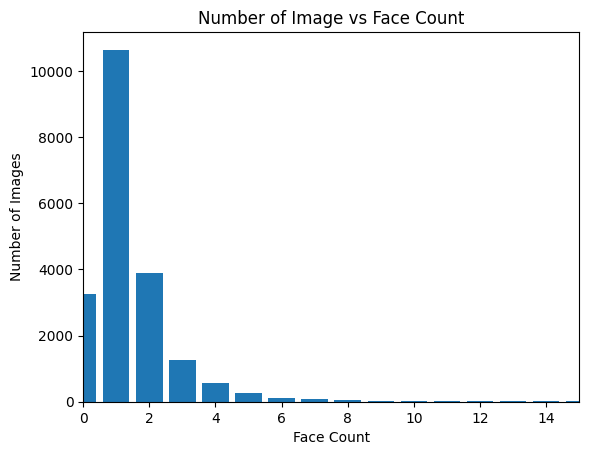

In [23]:
facelist = [] 
x = set(face_count_dict.values())
for i in x:
    facelist.append(sum(1 for v in face_count_dict.values() if v == i))

plt.bar(list(x), facelist)
plt.title('Number of Image vs Face Count')
plt.ylabel('Number of Images')
plt.xlabel('Face Count')
plt.xlim((0,15))
plt.show()

* validation dataset

In [24]:
# mtcnnModel(valid_data_single,'validation', 5062);
# dlibModel(valid_data_single,'validation', 5062);

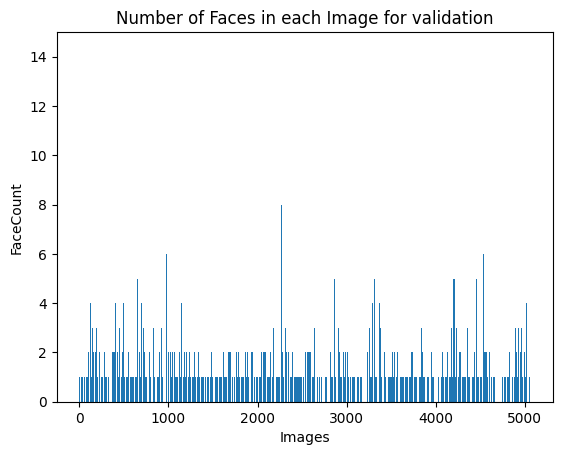

In [25]:
with open('validation_face_count_dict_mtcnn.pkl', 'rb') as f:
    face_count_dict = pickle.load(f)


plt.bar(face_count_dict.keys(), face_count_dict.values())
plt.title('Number of Faces in each Image for validation')
plt.ylim((0,15))
plt.xlabel('Images')
plt.ylabel('FaceCount')
plt.show()

In [26]:
face_count_mean = np.mean(list(face_count_dict.values()))
face_count_var = np.var(list(face_count_dict.values()))
face_count_std = np.std(list(face_count_dict.values()))
print(f"mean: {face_count_mean}")
print(f"variance: {face_count_var}")
print(f"Standard Deviation: {face_count_std}")

mean: 1.4075464243382063
variance: 10.825411245869274
Standard Deviation: 3.290199271452912


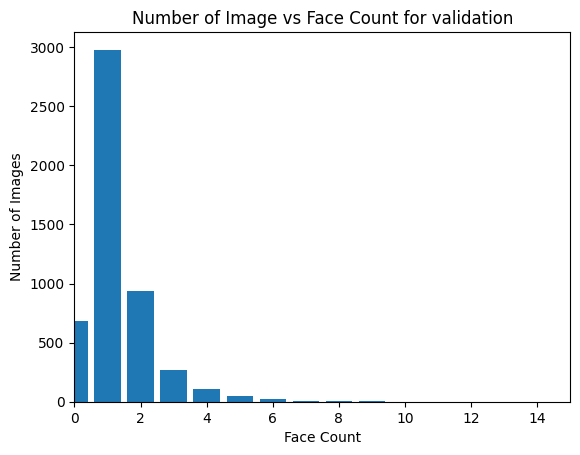

In [27]:
facelist = [] 
x = set(face_count_dict.values())
for i in x:
    facelist.append(sum(1 for v in face_count_dict.values() if v == i))

plt.bar(list(x), facelist)
plt.title('Number of Image vs Face Count for validation')
plt.ylabel('Number of Images')
plt.xlabel('Face Count')
plt.xlim((0,15))
plt.show()

* test dataset

In [28]:
# mtcnnModel(test_data_single,'test', 5066);
# dlibModel(test_data_single,'test', 5066);

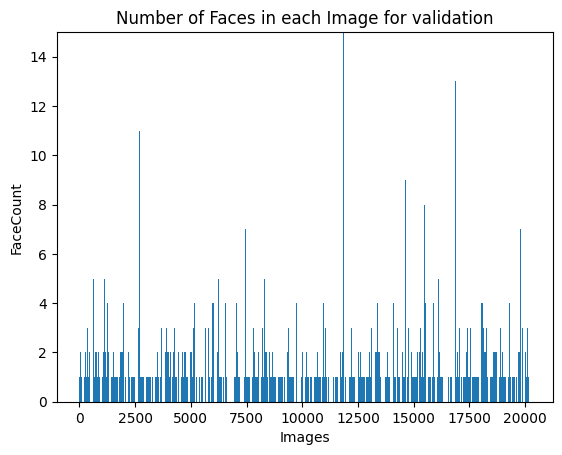

In [29]:
with open('test_face_count_dict_mtcnn.pkl', 'rb') as f:
    face_count_dict = pickle.load(f)


plt.bar(face_count_dict.keys(), face_count_dict.values())
plt.title('Number of Faces in each Image for validation')
plt.xlabel('Images')
plt.ylabel('FaceCount')
plt.ylim((0,15))
plt.show()

In [30]:
face_count_mean = np.mean(list(face_count_dict.values()))
face_count_var = np.var(list(face_count_dict.values()))
face_count_std = np.std(list(face_count_dict.values()))
print(f"mean: {face_count_mean}")
print(f"variance: {face_count_var}")
print(f"Standard Deviation: {face_count_std}")

mean: 1.473814229249012
variance: 3.9426937520504923
Standard Deviation: 1.985621754526902


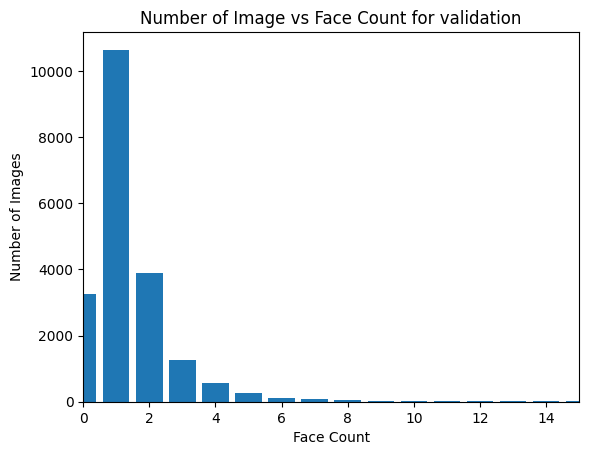

In [31]:
facelist = [] 
x = set(face_count_dict.values())
for i in x:
    facelist.append(sum(1 for v in face_count_dict.values() if v == i))

plt.bar(list(x), facelist)
plt.title('Number of Image vs Face Count for validation')
plt.ylabel('Number of Images')
plt.xlabel('Face Count')
plt.xlim((0,15))
plt.show()

> The majority of images have one face on average. This is fixed for train, test, and validation datasets. there are some zero in the result becasue some images have special effect like bluring , contrast,...  these  effect should be compensate by augmentation in next phase.

## E: Correlation of each Sentiment with dialogue length

In [32]:
nSentiment = np.array([[int(j),len(i.split())] for i,j in zip(training_data.english_text, training_data.sentiment)])

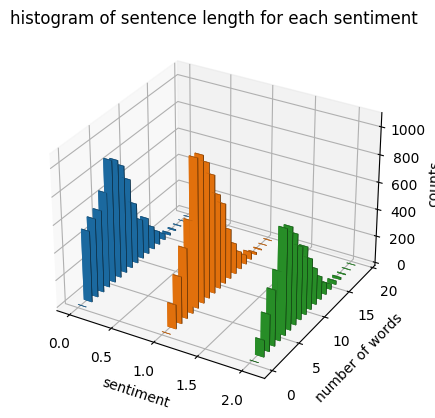

In [33]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xedges = range(2+2)
yedges = range(nSentiment[:,1].max()+2)
hist, xedges, yedges = np.histogram2d(nSentiment[:,0], nSentiment[:,1],bins=(xedges,yedges))

# Construct arrays for the anchor positions
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions
dx = dy = 0.1 * np.ones_like(zpos)
dz = hist.ravel()
idx = yedges[:-1].shape[0]
for i in range(3):
    ax.bar3d(xpos[idx*i:idx*(i+1)], ypos[idx*i:idx*(i+1)], zpos, dx, dy, dz[idx*i:idx*(i+1)], zsort='average')
ax.set_xlabel('sentiment')
ax.set_ylabel('number of words')
ax.set_zlabel('counts')
ax.set_title('histogram of sentence length for each sentiment')
plt.show()

> We can understand from the above figure that the length of sentences has no effect on sentiment because all three sentiment distributions over the length of sentences are almost the same. in other words correlation between sentiment and length of words is low. in addition, the plot shows that the mean of each sentiment is the same


## F: Time-patterns of sentiment change in a conversation

In [34]:
def timeSentimentPattern(data):
    x = []
    for i in data.image_index:
        y = []
        for j in data.sentiment[i[0]:i[-1]+1]:
            if len(y) > 0 and j != y[-1]:
                y.extend(j)
            elif len(y) == 0:
                y.extend(j)
        x.append(''.join(y))
    return sorted(x,key=len)

* training data

Text(0.5, 0, 'Sentiment patterns over time')

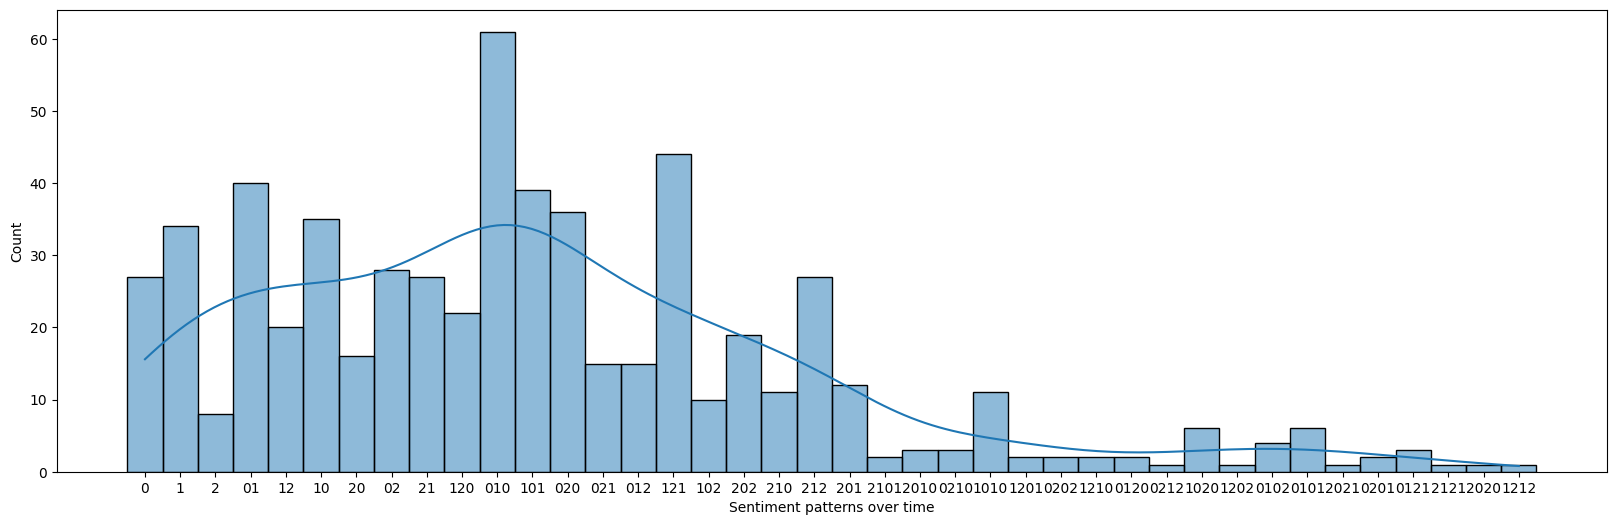

In [35]:
plt.figure(figsize=(20,6))
ax = sb.histplot(timeSentimentPattern(training_data)[0:600], kde=True);
plt.xlabel("Sentiment patterns over time")

* validation data 

Text(0.5, 0, 'Sentiment patterns over time')

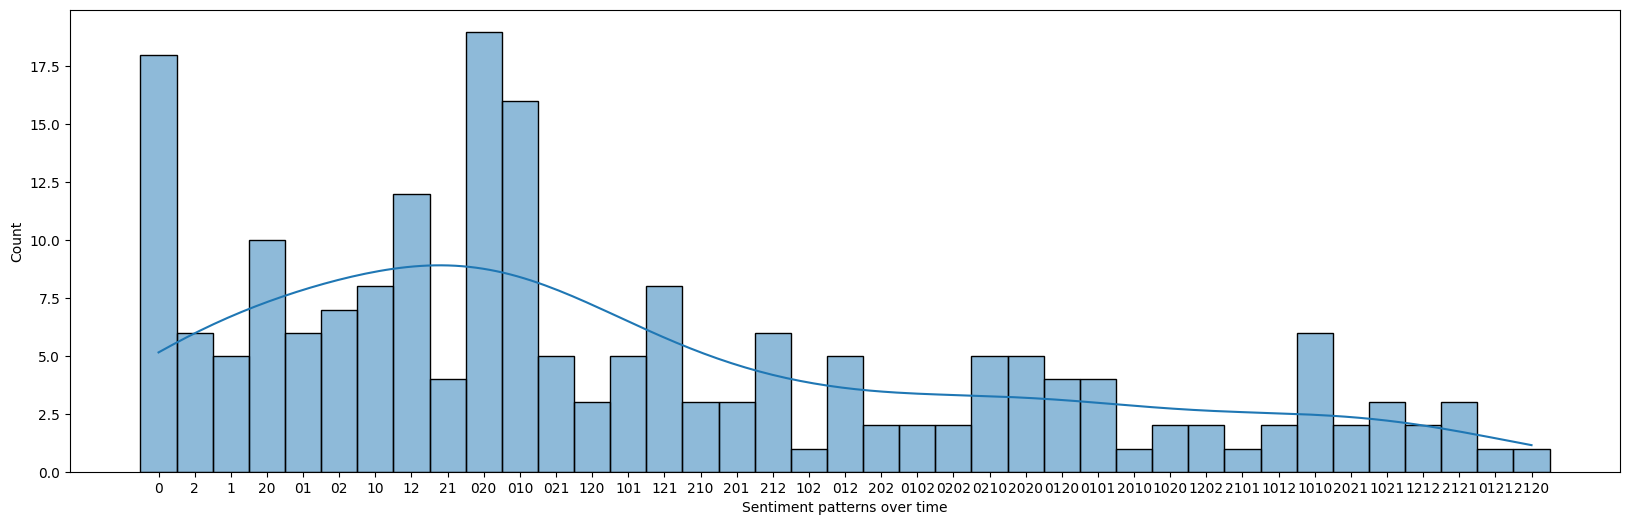

In [36]:
plt.figure(figsize=(20,6))
sb.histplot(timeSentimentPattern(valid_data)[0:200], kde=True);
plt.xlabel("Sentiment patterns over time")

* test data

Text(0.5, 0, 'Sentiment patterns over time')

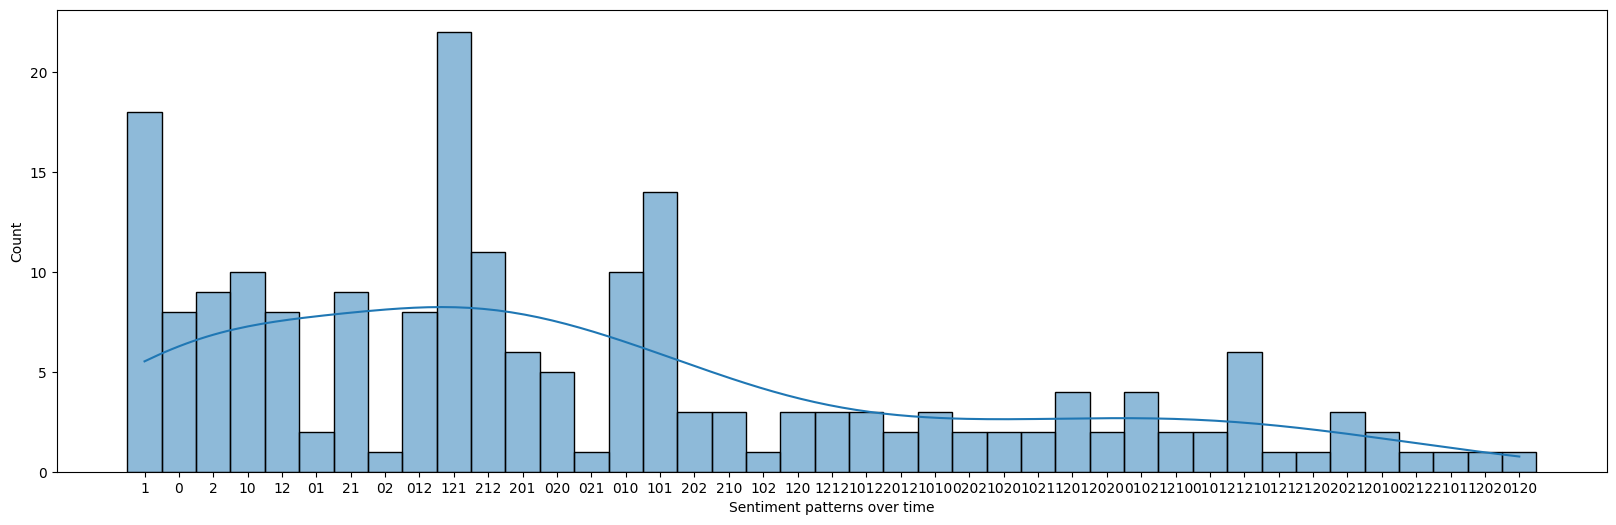

In [37]:
plt.figure(figsize=(20,6))
sb.histplot(timeSentimentPattern(test_data)[0:200], kde=True);
plt.xlabel("Sentiment patterns over time")

> * For better display in each histogram, time patterns with low value are not displayed

> obviously, short patterns are more frequent than long patterns, and the histogram of sentiment patterns over time for training, test, and validation Datasets is different from each other.


## G: Comaparison between Number of Histogram classes and number of possible pattern

In [38]:
#TODO
def comparison(data):
    from math import floor
    lengthConv = [len(index) for index in data.image_index]
    print("number of class in pattern histogram :", len(set(timeSentimentPattern(data))))
    print("number of possible pattern :", 3*(2**(floor(np.mean(lengthConv))+1)-1))

> in theory, the number of possibilities in a fixed number of n frames is $( 3 * 2 ^ {n-1} ) $  because the first stage has 3 selections of sentiments but others have two selections.also if there is a redundancy in Successive sentiment, the length of the sentiment pattern is reduced by one, and one of factors two in the formula is reduced too, this pattern is continued to reduce just one sentiment by 3 selections. so the ***final formula*** for computing the number of the possible pattern is : $( 3 * (2 ^ {n} -1) ) $

* training data

In [39]:
comparison(training_data)

number of class in pattern histogram : 681
number of possible pattern : 3069


* validation data

In [40]:
comparison(valid_data)

number of class in pattern histogram : 250
number of possible pattern : 6141


* test data

In [41]:
comparison(test_data)

number of class in pattern histogram : 255
number of possible pattern : 3069


> it s can be known all of the possibilities in the data didn't occur and this due to the difference between theory and practical